# Model Validation

Create a plot to compare CESM-LENS climatology to neural network climatology.

In [2]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
#import esmtools as et
from matplotlib import gridspec
from mpl_toolkits.basemap import Basemap

In [3]:
EBUS = ['CalCS', 'HumCS', 'CanCS', 'BenCS']

# CESM-LENS Manipulation

In [5]:
lens_output, lens_lat, lens_lon = ( {} for i in range(3) )
for idx in EBUS:
    print(('Operating on : %s ...') %idx)
    fileDir = '/glade/work/rbrady/EBUS_BGC_Variability/FG_CO2/' + idx + '/'
    if idx == 'CalCS' or idx == 'HumCS' :
        ds_lens = xr.open_mfdataset(fileDir + '*.nc', concat_dim='ensemble')
    else:
        ds_lens = xr.open_mfdataset(fileDir + 'extended_domain/' + 'extended_domain*.nc', concat_dim='ensemble')
    # Fix quirk where TLAT/TLONG are coordinates which dissapear when you do ensemble mean.
    if idx == 'HumCS':
        ds_lens['TLAT'] = (('nlat', 'nlon'), ds_lens['TLAT'][0])
        ds_lens['TLONG'] = (('nlat', 'nlon'), ds_lens['TLONG'])
    else:
        ds_lens['TLAT'] = (('nlat', 'nlon'), ds_lens['TLAT'][0])
        ds_lens['TLONG'] = (('nlat', 'nlon'), ds_lens['TLONG'][0])
    ds_lens = ds_lens.mean(dim='ensemble')
#    x0,x1,y0,y1 = visual_bounds(idx, 'model')
#    a, c = et.filtering.find_indices(ds_lens['TLAT'].values, ds_lens['TLONG'].values,
#                    y0, x0)
#    b, d = et.filtering.find_indices(ds_lens['TLAT'].values, ds_lens['TLONG'].values,
#                    y1, x1)
#    ds_lens = ds_lens.isel(nlat=slice(a, b), nlon=slice(c,d))
    ds_lens = ds_lens.sel(time=slice('1982-01', '2015-12')).mean(dim='time')
    lens_output[idx] = pd.DataFrame(ds_lens['FG_CO2'].values)
    lens_lat[idx] = pd.DataFrame(ds_lens['TLAT'].values)
    lens_lon[idx] = pd.DataFrame(ds_lens['TLONG'].values)
    del ds_lens

Operating on : CalCS ...


/glade/u/home/rbrady/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Operating on : HumCS ...


/glade/u/home/rbrady/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Operating on : CanCS ...


/glade/u/home/rbrady/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Operating on : BenCS ...


/glade/u/home/rbrady/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


# SOM-FFN Manipulation

In [7]:
obs_output, obs_lat, obs_lon = ( {} for i in range(3) )
fileDir = '/glade/work/rbrady/Landschuetzer_pCO2/'
ds_obs = xr.open_dataset(fileDir + 'spco2_1982-2015_MPI_SOM-FFN_v2016.nc', decode_times=False)
times = pd.date_range('1982-01', '2016-01', freq='M')
ds_obs['time'] = times
ds_obs.attrs = {}
X, Y = np.meshgrid(ds_obs['lon'].values, ds_obs['lat'].values)
ds_obs['LON'] = (('lat','lon'), X)
ds_obs['LAT'] = (('lat','lon'), Y)
ds_obs = ds_obs.mean(dim='time')
for idx in EBUS:
    print(('Operating on : %s ...') %idx)
#    x0,x1,y0,y1 = visual_bounds(idx, 'obs')
#    a, c = et.filtering.find_indices(ds_obs['LAT'].values, ds_obs['LON'].values,
#                    y0, x0)
#    b, d = et.filtering.find_indices(ds_obs['LAT'].values, ds_obs['LON'].values,
#                    y1, x1)  
#    ds_temp = ds_obs.isel(lat=slice(a,b), lon=slice(c,d))
    temp_data = ds_obs['fgco2_raw'].values
    mask = ( temp_data > 1e19 )
    temp_data[mask] = np.nan
    obs_output[idx] = pd.DataFrame(ds_obs['fgco2_raw'].values)
    obs_lat[idx] = pd.DataFrame(ds_obs['LAT'].values)
    obs_lon[idx] = pd.DataFrame(ds_obs['LON'].values)
#    del ds_temp                                    

Operating on : CalCS ...
Operating on : HumCS ...
Operating on : CanCS ...
Operating on : BenCS ...


/glade/u/home/rbrady/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


# Visualization

In [8]:
def visual_bounds(EBU):
    if EBU == "CalCS":
        lat1 = 27
        lat2 = 45
        lon1 = -133
        lon2 = -110
    elif EBU == 'HumCS':
        lat1 = -20
        lat2 = -2
        lon1 = -90
        lon2 = -70
    elif EBU == 'CanCS':
        lat1 = 14
        lat2 = 32
        lon1 = -25
        lon2 = -10
    elif EBU == 'BenCS':
        lat1 = -35
        lat2 = -15
        lon1 = 5
        lon2 = 20
    return lat1,lat2,lon1,lon2

In [12]:
def setup_map(ax, lat1, lat2, lon1, lon2, lat_labels, lon_labels):
    m = Basemap(projection='merc',
                lat_0=(lat1+lat2)/2,
                lon_0=(lon1+lon2)/2,
                llcrnrlon=lon1,
                urcrnrlon=lon2,
                llcrnrlat=lat1,
                urcrnrlat=lat2,
                fix_aspect=False,
                resolution='c')
    m.drawcoastlines(color='#000000')
#    m.fillcontinents(color='#000000')
    m.drawmapboundary(fill_color='white')
#    m.drawparallels(np.arange(lat1, lat2+1, 3),
#                   labels=[False,True,False,False], size=20,
#                   color='w')
    m.drawparallels(lat_labels,
                    labels=[False,True,False,False], size=20,
                    color='w')
    m.drawmeridians(lon_labels,
                   labels=[False, False, True, False], size=20,
                   color='w')

    return m

In [15]:
def map_upwelling_clim(ax, EBU, typ, lat_label, lon_labels):
    if typ == 'obs':
        lon = obs_lon[EBU].values
        lat = obs_lat[EBU].values
        data = obs_output[EBU].values
        data = np.ma.array(data, mask=np.isnan(data))
    elif typ == 'model':
        lon = lens_lon[EBU].values
        lat = lens_lat[EBU].values
        data = lens_output[EBU].values
        data = np.ma.array(data, mask=np.isnan(data))
    lat1,lat2,lon1,lon2 = visual_bounds(EBU)
    if typ == 'model' and EBU != 'BenCS':
        lon1 = 360 + lon1; lon2 = 360 + lon2;
    if typ == 'obs':
        m = setup_map(ax, lat1, lat2, lon1, lon2, lat_label, lon_labels)
    elif typ == 'model':
        m = setup_map(ax, lat1, lat2, lon1, lon2, lat_label, lon_labels)
    m.contourf(lon, lat, data, np.linspace(-2.5, 2.5, num=21, endpoint=True),
               latlon=True, cmap="RdBu_r", extend="both")
    return m

Load in just the analysis region to plot over the figure.

/glade/u/home/rbrady/miniconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/u/home/rbrady/miniconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/glade/u/home/rbrady/miniconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3675: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

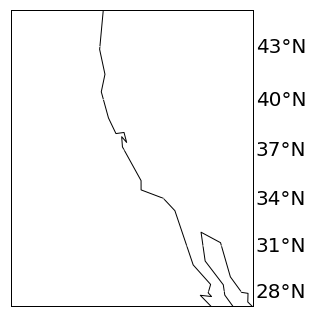

In [16]:
names = ['California Current',
         'Humboldt Current',
         'Canary Current',
         'Benguela Current']
lat_labels = {'CalCS': np.arange(28,46,3),
              'HumCS': np.arange(-19,0,3),
              'CanCS': np.arange(15,33,3),
              'BenCS': np.arange(-34,-15,3)}
lon_labels = {'CalCS': np.arange(-132,-110,5),
              'HumCS': np.arange(-88,-69,4),
              'CanCS': np.arange(-24,-9,3),
              'BenCS': np.arange(6,21,3)}

fig = plt.figure(figsize=(20,12))
counter_top = 1
counter_mid = 5
for idx in EBUS:
    # Landscheutzer Climatology (Top)
    ax = fig.add_subplot(2, 4, counter_top)
    m = map_upwelling_clim(ax, idx, 'obs', lat_labels[idx], [])
    if counter_top == 1:
        plt.ylabel('Landschuetzer et al. 2015 (1982-2015)', size=18)    
    plt.title(names[counter_top-1], size=25)
    counter_top += 1
    # CESM-LENS Climatology (Bottom)
    ax = fig.add_subplot(2, 4, counter_mid)
    m = map_upwelling_clim(ax, idx, 'model', lat_labels[idx], lon_labels[idx])
    if counter_mid == 5:
        plt.ylabel('CESM Large Ensemble (1982-2015)', size=18)   
        
    cbar = m.colorbar(location="bottom")
    cbar.set_ticks(np.arange(-2, 2.1, 1))
    cbar.ax.tick_params(labelsize=20, direction='out') 
    cbar.set_label('Sea-Air CO$_{2}$ Flux (mol/m$^{2}$/yr)', size=20)
    counter_mid +=1

fig.tight_layout()

#et.vis.savefig('figure1_lonlabels', extension='.eps', dpi=300)


## Figure out region bounds

In [ ]:
def visualize(ax, EBU, loc, lat_labels):
    """
    Here loc is "top" or "bottom." Top will be raw pcolormesh. Bottom will be just sliced region of interest.
    Will do the rest in Illustrator.
    """
    if loc == 'top':
        lon = lens_lon[EBU].values
        lat = lens_lat[EBU].values
        data = lens_output[EBU].values
        data = np.ma.array(data, mask=np.isnan(data))
    elif loc == 'bottom':
        filepath = '/glade/p/work/rbrady/EBUS_BGC_Variability/FG_CO2/' + EBU + '/filtered_output/'
        ds = xr.open_dataset(filepath + EBU.lower() + '-FG_CO2-forced-signal-chavez-800km.nc').mean('time')
        lon = ds['TLONG'].values
        lat = ds['TLAT'].values
        data = ds['FG_CO2'].values
        data = np.ma.array(data, mask=np.isnan(data))
    lat1,lat2,lon1,lon2 = visual_bounds(EBU)
    if EBU != 'BenCS':
        lon1 = lon1+360; lon2 = lon2+360;
    m = setup_map(ax, lat1, lat2, lon1, lon2, lat_labels)
#    m.contourf(lon, lat, data, np.linspace(-2.5, 2.5, num=21, endpoint=True),
#               latlon=True, cmap="RdBu_r", extend="both")
    m.pcolormesh(lon, lat, data, latlon=True, cmap="RdBu_r", vmin=-2.5, vmax=2.5)
    return m

In [ ]:
names = ['California Current',
         'Humboldt Current',
         'Canary Current',
         'Benguela Current']
lat_labels = {'CalCS': np.arange(28,46,3),
              'HumCS': np.arange(-19,0,3),
              'CanCS': np.arange(15,33,3),
              'BenCS': np.arange(-34,-15,3)}
fig = plt.figure(figsize=(20,12))
counter_top = 1
counter_mid = 5
for idx in EBUS:
    # Landscheutzer Climatology (Top)
    ax = fig.add_subplot(2, 4, counter_top)
    m = visualize(ax, idx, 'top', lat_labels[idx])
    if counter_top == 1:
        plt.ylabel('Landschuetzer et al. 2015 (1982-2015)', size=18)    
    plt.title(names[counter_top-1], size=25)
    counter_top += 1
    # CESM-LENS Climatology (Middle)
    ax = fig.add_subplot(2, 4, counter_mid)
    m = visualize(ax, idx, 'bottom', lat_labels[idx])
    if counter_mid == 5:
        plt.ylabel('CESM Large Ensemble (1982-2015)', size=18)   
        
    cbar = m.colorbar(location="bottom")
    cbar.set_ticks(np.arange(-2, 2.1, 1))
    cbar.ax.tick_params(labelsize=20, direction='out') 
    cbar.set_label('Sea-Air CO$_{2}$ Flux (mol/m$^{2}$/yr)', size=20)
    counter_mid +=1

fig.tight_layout()

#et.vis.savefig('analysis_gridcells')
et.vis.savefig('analysis_gridcells', extension='.eps', dpi=200)
